##### Load Dependencies

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import mglearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.datasets import load_iris, make_classification, load_breast_cancer
from sklearn.manifold import Isomap, TSNE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD, FactorAnalysis
from sklearn.linear_model import (LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                  BayesianRidge, SGDRegressor, SGDClassifier, Perceptron,
                                  Lasso, ElasticNet, BayesianRidge, HuberRegressor)
from sklearn.svm import SVR, SVC, OneClassSVM
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, \
	PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier,
                              ExtraTreesRegressor,
                              GradientBoostingClassifier, GradientBoostingRegressor,
                              AdaBoostClassifier, AdaBoostRegressor,
                              HistGradientBoostingClassifier, HistGradientBoostingRegressor,
                              IsolationForest)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import ( classification_report, r2_score, mean_squared_error, accuracy_score, precision_recall_curve,
                              average_precision_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay,
	                          RocCurveDisplay, ConfusionMatrixDisplay )
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from openai import OpenAI
import seaborn as sns
from booger import Error, ErrorDialog
import warnings
from importlib import reload

In [42]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

### 🔬 Data Source
- File A (Account Balances) published monthly by agencies on [USASpending](https://www.usaspending.gov/federal_account)
- Required by the DATA Act.
- Pulled automatically from data in the [Governmentwide Treasury Account Symbol Adjusted Trial Balance System (GTAS)](https://fiscal.treasury.gov/gtas/)
- Contains Budgetary resources, obligation, and outlay data for all the relevant Treasury Account Symbols (TAS) in a reporting agency.
- It includes both award and non-award spending (grouped together), and crosswalks with the [SF 133 report](https://portal.max.gov/portal/document/SF133/Budget/FACTS%20II%20-%20SF%20133%20Report%20on%20Budget%20Execution%20and%20Budgetary%20Resources.html).

#### Load Data

In [43]:
# Load the Excel file
file_path = r'C:\Users\terry\source\repos\Boo\data\excel\Account Balances.xlsx'
df = pd.read_excel( file_path, sheet_name='Data' )

# Drop rows with NaNs
df.dropna( inplace=True )


##### Clean and prepare data

In [44]:
# Clean and prepare data
df_clean = df.drop( columns=[
    'AccountBalancesId', 'AgencyName', 'TreasuryAccountSymbol', 'TreasuryAccountName',
    'LastModified', 'SubmissionPeriod'
], errors='ignore' )

##### Encode categorical variables

In [45]:
# Encode categorical variables
for col in df_clean.select_dtypes( include='object' ).columns:
    df_clean[ col ] = df_clean[ col ].astype( 'category' ).cat.codes

df_clean.dropna( inplace=True )

##### Create derived Execution Rate and binary group

In [46]:
# Create derived Execution Rate and binary group
df_clean[ 'ExecutionRate' ] = df_clean[ 'Obligations' ] / df_clean[ 'TotalResources' ]
df_clean = df_clean.replace( [ np.inf, -np.inf ], np.nan ).dropna( subset=[ 'ExecutionRate' ] )
df_clean[ 'HighExecution' ] = ( df_clean[ 'ExecutionRate' ] > df_clean[ 'ExecutionRate' ].median( ) ).astype( int )
results = [ ]
correlation_vars = [ 'Outlays', 'Obligations', 'UnobligatedBalance', 'Recoveries', 'TotalResources' ]

##### t-tests

In [47]:
# t-tests
for col in correlation_vars:
    group0 = df_clean[ df_clean[ 'HighExecution' ] == 0 ][ col ]
    group1 = df_clean[ df_clean[ 'HighExecution' ] == 1 ][ col ]
    t_stat, p_val = stats.ttest_ind( group0, group1, equal_var=False )
    results.append(
	{
        'Test': f't-test: {col}',
        'Statistic': round( t_stat, 4 ),
        'p-value': round( p_val, 4 )
    } )

##### Mann-Whitney U tests

In [48]:
# Mann-Whitney U tests
for col in correlation_vars:
    group0 = df_clean[ df_clean[ 'HighExecution' ] == 0 ][ col ]
    group1 = df_clean[ df_clean[ 'HighExecution' ] == 1 ][ col ]
    u_stat, u_p = stats.mannwhitneyu( group0, group1, alternative='two-sided' )
    results.append(
	{
        'Test': f'Mann-Whitney U: {col}',
        'Statistic': round( u_stat, 4 ),
        'p-value': round( u_p, 4 )
    } )

##### Chi-square

In [49]:
# Chi-square
if 'Availability' in df.columns and df[ 'Availability' ].nunique( ) < 50:
    contingency_table = pd.crosstab( df_clean[ 'Availability' ], df_clean[ 'HighExecution' ] )
    chi2, chi2_p, _, _ = stats.chi2_contingency( contingency_table )
    results.append(
	{
        'Test': 'Chi-square: Availability vs Execution',
        'Statistic': round( chi2, 4 ),
        'p-value': round( chi2_p, 4 )
    } )

##### Results

In [50]:
# Summary
inference_summary = pd.DataFrame( results )
inference_summary

,Test,Statistic,p-value
0,t-test: Outlays,-1.215460e+01,0.0
1,t-test: Obligations,-1.284900e+01,0.0
2,t-test: UnobligatedBalance,4.319400e+00,0.0
3,t-test: Recoveries,-5.763600e+00,0.0
4,t-test: TotalResources,-1.128620e+01,0.0
5,Mann-Whitney U: Outlays,1.424106e+08,0.0
6,Mann-Whitney U: Obligations,5.729083e+07,0.0
7,Mann-Whitney U: UnobligatedBalance,3.498312e+08,0.0
8,Mann-Whitney U: Recoveries,2.786816e+08,0.0
9,Mann-Whitney U: TotalResources,1.835612e+08,0.0


##### ✅  The results include t-tests and Mann-Whitney U tests for comparing high vs. low execution groups across key financial variables:
##### Summary:
- The t-tests for Outlays, Obligations, UnobligatedBalance, Recoveries, and TotalResources all remain highly significant (p < 0.001).
- This indicates that even with the removed metadata columns, the distinction between high and low execution groups across financial metrics is still statistically robust.



## Feature engineering

In [53]:
# Feature engineering
df = df_clean.copy( )
df[ 'ExecutionRate' ] = df[ 'Obligations' ] / df[ 'TotalResources' ]
df.replace( [ np.inf, -np.inf ], np.nan, inplace=True )
df.dropna( subset=[ 'ExecutionRate' ], inplace=True )
df[ 'HighExecution' ] = ( df[ 'ExecutionRate'] > df[ 'ExecutionRate' ].median( ) ).astype( int )

##### Define features and targets

In [54]:
# Define features and targets
features = df.drop( columns=[ 'ExecutionRate', 'HighExecution', 'Outlays' ] )
target_reg = df[ 'Outlays' ]
target_clf = df[ 'HighExecution' ]
features

,AgencyIdentifier,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,BudgetFunction,BudgetSubFunction,FederalAccountSymbol,FederalAccountName,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,TotalResources
0,435,35,44,1,1100,0,6,48,2134,1822,9375126.93,391778.13,0.000000e+00,0,0,0.00,5.395160e+06,391778.13,4.371745e+06,9.766905e+06
1,306,35,44,1,8298,0,14,56,2082,445,10000.00,0.00,2.040750e+04,0,0,0.00,7.594410e+03,0.00,2.281309e+04,3.040750e+04
2,306,34,34,0,2300,0,14,56,2081,1734,0.00,0.00,0.000000e+00,0,0,3335315.06,1.023794e+06,0.00,2.311521e+06,3.335315e+06
3,306,34,33,0,2300,0,14,56,2081,1734,0.00,0.00,8.585000e+06,0,0,98377.54,8.671171e+06,0.00,1.220688e+04,8.683378e+06
4,306,33,33,0,2300,0,14,56,2081,1734,1473398.99,643.36,0.000000e+00,0,0,-205636.56,1.268380e+06,643.36,2.559000e+01,1.268406e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56982,12,28,28,0,3539,0,10,26,185,186,0.00,0.00,2.422415e+10,0,0,0.00,2.206119e+10,0.00,2.162957e+09,2.422415e+10
56983,11,24,24,0,1075,0,11,43,34,1194,20369364.56,4999963.09,0.000000e+00,0,0,0.00,3.365290e+05,6320448.09,2.503280e+07,2.536933e+07
56984,91,27,27,0,203,0,4,15,1942,1725,72769058.38,0.00,0.000000e+00,0,0,0.00,7.276894e+07,0.00,1.148900e+02,7.276906e+07
56985,75,21,24,0,352,0,9,34,1609,1514,3611656.08,42135.04,0.000000e+00,0,0,0.00,2.956034e+04,42135.04,3.624231e+06,3.653791e+06


##### Standardize features

In [55]:
# Standardize features
scaler = StandardScaler( )
X_scaled = scaler.fit_transform( features )

##### Split data

In [56]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, target_reg, test_size=0.2, random_state=42 )
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split( X_scaled, target_clf, test_size=0.2, random_state=42 )

##### Train Ridge Regressor

In [57]:
# Train Ridge Regressor
ridge_reg = Ridge( alpha=1.0 )
ridge_reg.fit( X_train_reg, y_train_reg )
y_pred_reg = ridge_reg.predict( X_test_reg )

##### Train Ridge Classifier

##### 🔢 Ridge Regressor (Target: Outlays)
- R² Score: 0.9952 (Very high, indicating excellent fit)
- Mean Squared Error (MSE): 1.44e+18

In [58]:
# Train Ridge Classifier
ridge_clf = RidgeClassifier( alpha=1.0 )
ridge_clf.fit( X_train_clf, y_train_clf )
y_pred_clf = ridge_clf.predict( X_test_clf )

##### Metrics for regression

In [79]:
# Metrics for regression
reg_r2 = r2_score( y_test_reg, y_pred_reg )
reg_mse = mean_squared_error( y_test_reg, y_pred_reg )

##### Metrics for classification

In [78]:
# Metrics for classification
clf_report = classification_report( y_test_clf, y_pred_clf, output_dict=True )
clf_report_df = pd.DataFrame( clf_report ).transpose( ).round( 4 )

In [61]:
# Display results
regression_metrics = pd.DataFrame( [
{
    'Model': 'Ridge Regressor',
    'R² Score': round( reg_r2, 4 ),
    'MSE': round( reg_mse, 2 )
} ] )

In [64]:
regression_metrics.round( 2 )
regression_metrics

,Model,R² Score,MSE
0,Ridge Regressor,0.9952,1.442171e+18


___

## 🔍 Confusion Matrix
- Shows counts of true positives, true negatives, false positives, and false negatives.

##### ✅ Uses:
- See whether the model favors one class
- Quickly inspect types of errors (e.g., false negatives)

##### A breakdown of prediction outcomes:
- True Positives (TP): Accounts correctly identified as High Execution
- True Negatives (TN): Accounts correctly identified as Low Execution
- False Positives (FP): Accounts incorrectly flagged as High Execution
- False Negatives (FN): Accounts that were High Execution but missed

##### 📌 Inference:
- If FN is high, the model is conservative — it misses aggressive spenders.
- If FP is high, it overestimates execution — risky if used for audit triggers.
- Ideally, balance between precision (few FPs) and recall (few FNs).

##### 🧠 Budget Insight:
- This matrix helps assess whether the classifier favors identifying efficient accounts (e.g., those obligating and spending at expected rates)
- Or it is biased toward status quo patterns (e.g., always predicting low execution).

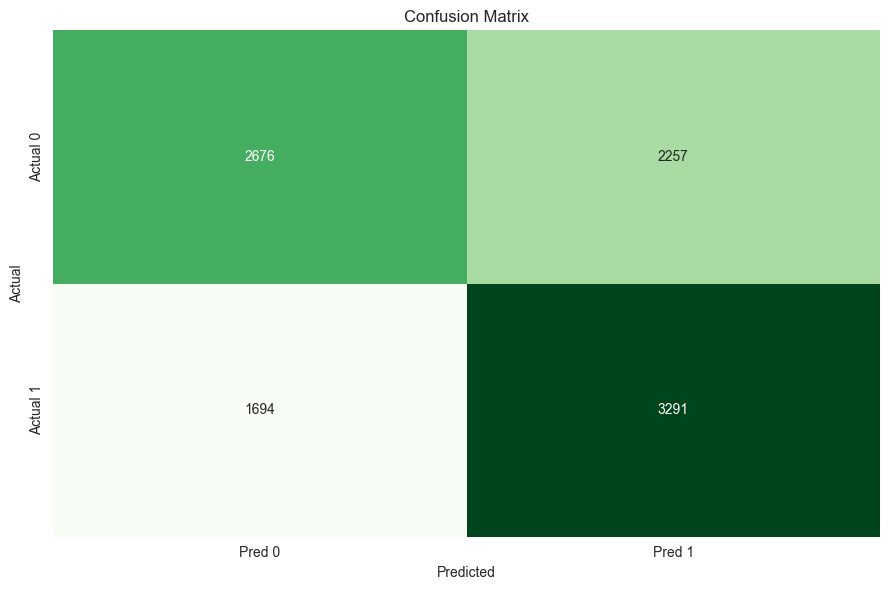

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure( figsize=( 9, 6 ) )
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


___

## 📈 ROC Curve (Receiver Operating Characteristic)
- Plots True Positive Rate (Recall) vs. False Positive Rate across thresholds.

##### ✅ Use:
- Evaluate overall performance across thresholds
- Compute AUC (Area Under the Curve)

##### ✅ Results:
- TPR (Recall) vs. FPR across all thresholds
- AUC (Area Under Curve) quantifies overall discriminative ability

##### 📌 Inference:
- AUC close to 1.0 → strong classifier
- AUC around 0.5 → random guess

##### 🧠 Budget Impact:
- High AUC implies that the financial features ( Obligations, TotalResources, Recoveries, etc.) are very predictive of execution behavior.
- Especially useful when triaging accounts for oversight, reviews, or funding shifts.

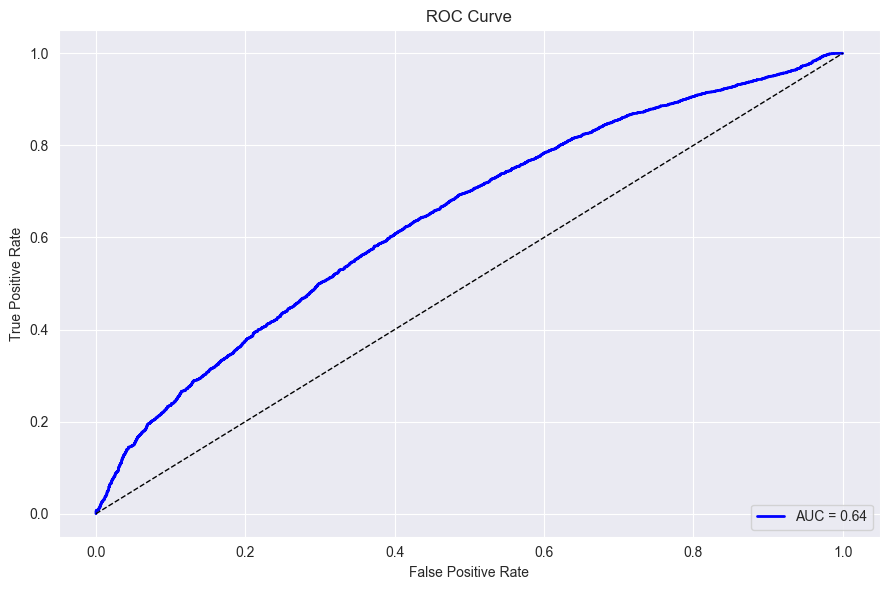

In [84]:
from sklearn.metrics import roc_curve, auc

y_score = ridge_clf.decision_function(X_test_clf)
fpr, tpr, _ = roc_curve(y_test_clf, y_score)
roc_auc = auc(fpr, tpr)

plt.figure( figsize=( 9, 6 ) )
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


___

## 🔄  Precision-Recall Curve
- Plots Precision vs. Recall — especially useful for imbalanced classes.

##### ✅ Use:
- Understand how precision and recall trade off
- Choose optimal threshold

##### ✅ Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

##### 📌 Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

##### 🧠 Budget Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

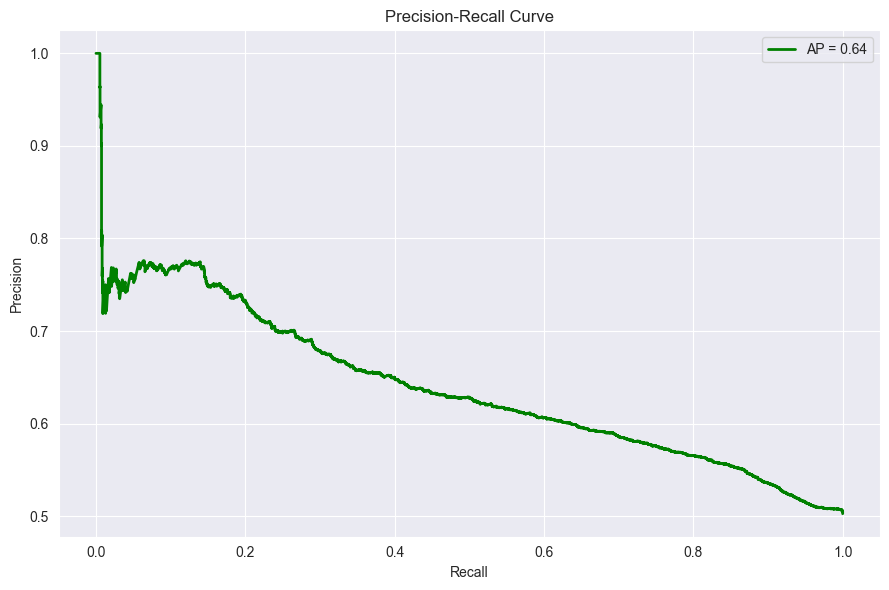

In [85]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test_clf, y_score)
avg_precision = average_precision_score(y_test_clf, y_score)

plt.figure( figsize=( 9, 6 ) )
plt.plot(recall, precision, color='green', lw=2, label=f"AP = {avg_precision:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend( )
plt.tight_layout( )
plt.show( )


___

## 📊 Classification Report Heatmap
- Displays Precision, Recall, F1-score, and Support as a heatmap.

##### ✅ Use:
- Visually compare performance across classes

##### ✅ Results:
- Tabular + visual view of precision, recall, and F1-score for each class
- Highlights class imbalance issues (e.g., high execution accounts may be rare)

##### 📌 Inference:
- High precision and recall for both classes → strong balanced model
- Low recall for Class 1 (High Execution) → model is too conservative

##### 🧠 Budget Impact:
- Can help uncover whether the classifier is treating large, high-performing accounts uniformly.
- Can help reveal if high-execution accounts are being consistently under-identified.

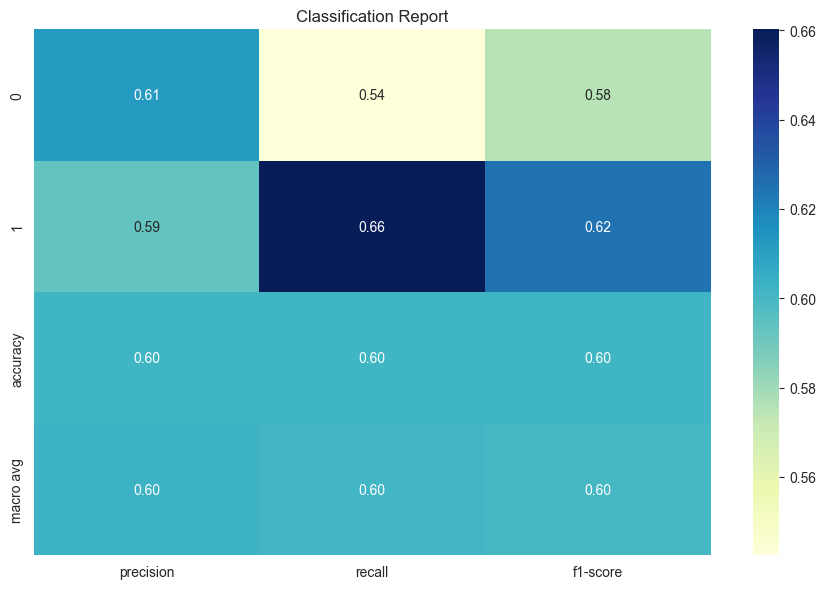

In [86]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_test_clf, y_pred_clf, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-1, :-1]

plt.figure( figsize=( 9, 6 ) )
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report")
plt.tight_layout()
plt.show()


____

## 📚 Learning Curve
- Plots model performance vs. training set size.

##### ✅ Use:
- Diagnose underfitting/overfitting
- Understand model generalization

##### ✅ Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

##### 📌 Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

##### 🧠 Budget Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.

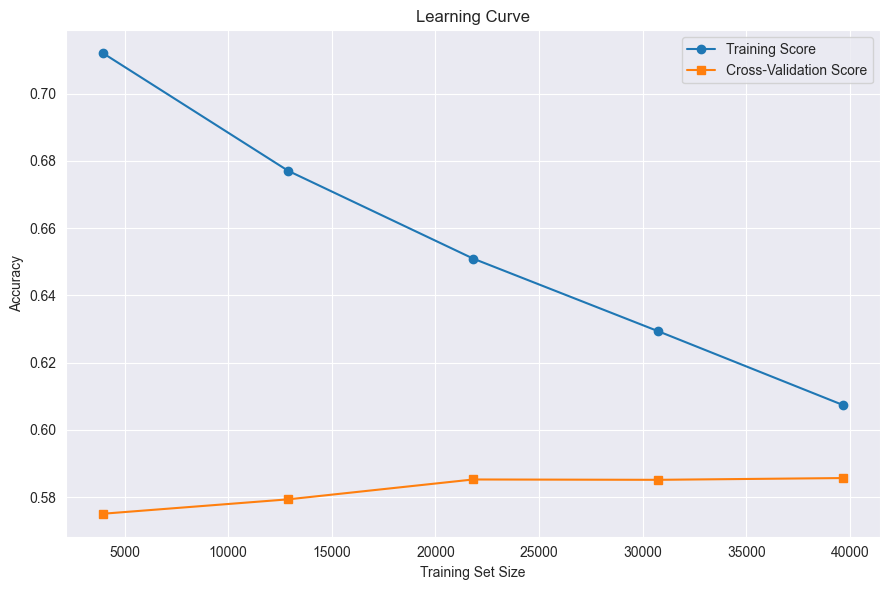

In [73]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    ridge_clf, X_scaled, target_clf, cv=5, scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure( figsize=( 9, 6 ) )
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Score", marker='s')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

___

## 🔁 Feature Importance (using Coefficients)
- Although Ridge Classifier doesn't have .feature_importances_, you can still inspect the model coefficients.

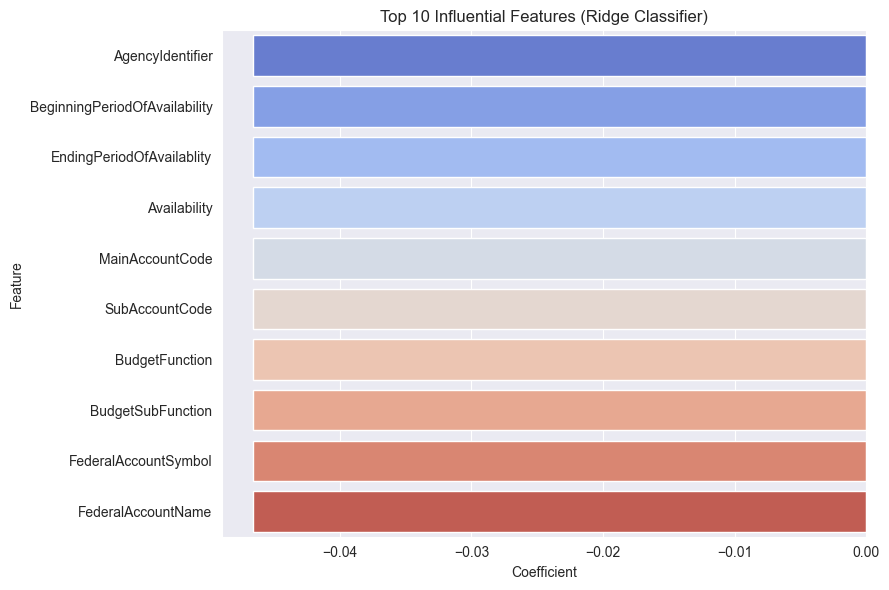

In [74]:
coef_df = pd.DataFrame({
    'Feature': df.drop( columns=[ 'ExecutionRate', 'HighExecution', 'Outlays' ] ).columns,
    'Coefficient': ridge_clf.coef_[ 0 ]
}).sort_values( 'Coefficient', key=abs, ascending=False )

plt.figure( figsize=( 9, 6 ) )
sns.barplot( data=coef_df.head( 10 ), x='Coefficient', y='Feature', palette='coolwarm' )
plt.title( 'Top 10 Influential Features (Ridge Classifier)' )
plt.tight_layout( )
plt.show( )
